<a href="https://colab.research.google.com/github/tarunrohit/Image-Segmentation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rslesepk
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rslesepk
  Resolved https://github.com/albumentations-team/albumentations to commit 40d208ddbd96006d15267a1b4ddea382dd22fa5e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires albucore==0.0.23, but you hav

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


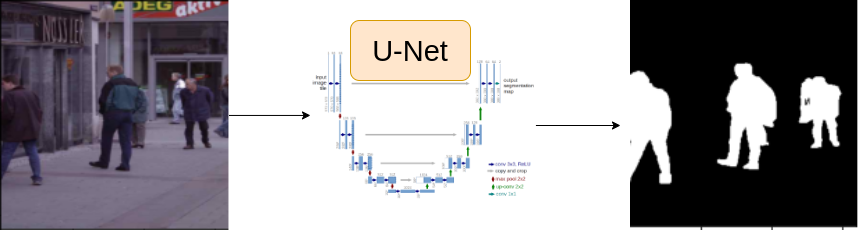

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content'

DEVICE='cuda'
EPOCHS= 25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row=df.iloc[4]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

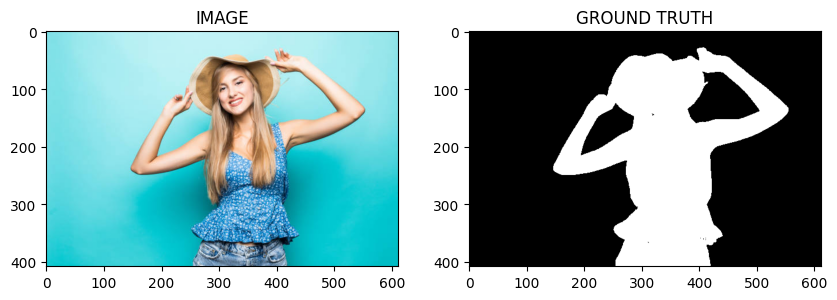

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,val_df= train_test_split(df,test_size=0.2,random_state=101)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def valid_augs():
    return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

#4.CREATING OWN DATASET

In [12]:
from torch.utils.data import Dataset

In [14]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import torch
import albumentations as A

class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    # Resize image and mask to have the same dimensions
    image = cv2.resize(image, (mask.shape[1], mask.shape[0])) # Resize image to mask dimensions
    # Alternative:
    # mask = cv2.resize(mask, (image.shape[1], image.shape[0])) # Resize mask to image dimensions

    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image=data['image']
      mask=data['mask']


    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image =torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [15]:
trainset=SegmentationDataset(train_df,train_augs())
validset=SegmentationDataset(val_df,valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


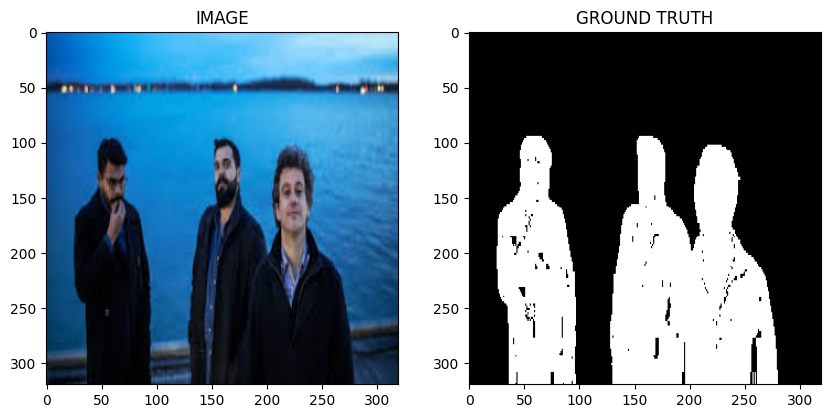

In [20]:
idx=6
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [21]:
from torch.utils.data import DataLoader

In [22]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [24]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [25]:
for image,mask in trainloader:
  break
print(f"one batch image shape: {image.shape}")
print(f"one batch mask shape: {mask.shape}")


one batch image shape: torch.Size([16, 3, 320, 320])
one batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [39]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [40]:
class SegmentationModel(nn.Module): # Inherit from nn.Module
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None): # Corrected mask to masks
    logits=self.arc(images)
    if masks !=None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2
    return logits

In [41]:
model=SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [49]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,mask in data_loader:
    images=images.to(DEVICE)
    # The loop variable was named 'mask' not 'masks'
    masks=mask.to(DEVICE)
    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  return total_loss/len(data_loader)


In [52]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for images,mask in data_loader:
      images=images.to(DEVICE)
      masks=mask.to(DEVICE)
      logits,loss=model(images,masks)
      total_loss+=loss.item()
  return total_loss/len(data_loader)

# Task 8 : Train Model

In [50]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [53]:
best_valid_loss=np.inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)
  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss=valid_loss
  print(f"Epoch:{i+1} Train_loss:{train_loss} Valid_loss:{valid_loss}")


SAVED MODEL
Epoch:1 Train_loss:0.32937975029150646 Valid_loss:0.38185954838991165
SAVED MODEL
Epoch:2 Train_loss:0.3003880908091863 Valid_loss:0.36595530062913895
Epoch:3 Train_loss:0.2904484728972117 Valid_loss:0.4372232258319855
SAVED MODEL
Epoch:4 Train_loss:0.23500264286994935 Valid_loss:0.2933553233742714
SAVED MODEL
Epoch:5 Train_loss:0.19372749030590058 Valid_loss:0.29234258085489273
Epoch:6 Train_loss:0.1894091213742892 Valid_loss:0.2985488660633564
SAVED MODEL
Epoch:7 Train_loss:0.17606684764226277 Valid_loss:0.28764019161462784
Epoch:8 Train_loss:0.1530328447620074 Valid_loss:0.37392783910036087
SAVED MODEL
Epoch:9 Train_loss:0.152496970196565 Valid_loss:0.2742902413010597
Epoch:10 Train_loss:0.14061694095532098 Valid_loss:0.31389692053198814
Epoch:11 Train_loss:0.1455038492878278 Valid_loss:0.3013771064579487
Epoch:12 Train_loss:0.15423506498336792 Valid_loss:0.30455031245946884
Epoch:13 Train_loss:0.1417832021911939 Valid_loss:0.31612424552440643
SAVED MODEL
Epoch:14 Train_

# Task 9 : Inference

In [63]:
idx=6
model.load_state_dict(torch.load("best_model.pt"))
image,mask=validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

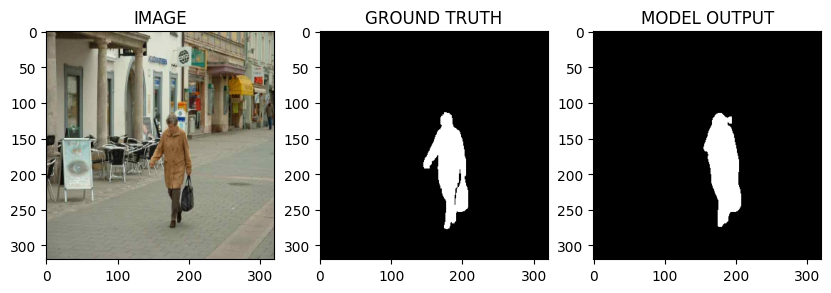

In [64]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya